In [2]:
from platform import python_version
print(python_version())

3.6.0


In [3]:
import os, audioread, pretty_midi, librosa, numpy as np
import util
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import defaultdict
from IPython.display import Audio as play
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_wav_files = shuffle(list(util.wavFileGen()))
len(all_wav_files)

1532

<h3> Explore some basic stats of the audio files </h3>

In [5]:
file_stats = []
for wav in tqdm(all_wav_files):
    with audioread.audio_open(wav) as f:
        file_stats.append([f.channels, f.samplerate, f.duration])

100%|██████████| 1532/1532 [00:00<00:00, 9970.45it/s]


In [6]:
# Check number of channels (all should be mono) and sample rate
set([fs[0] for fs in file_stats]), set([fs[1] for fs in file_stats])

({1}, {44100})

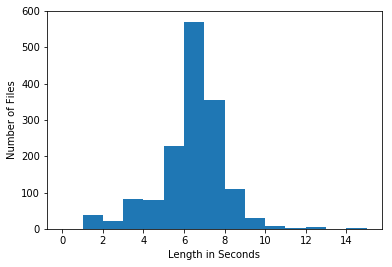

In [7]:
# plot the durations of the audio files
plt.ylabel('Number of Files')
plt.xlabel('Length in Seconds')
_ = plt.hist([fs[2] for fs in file_stats], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

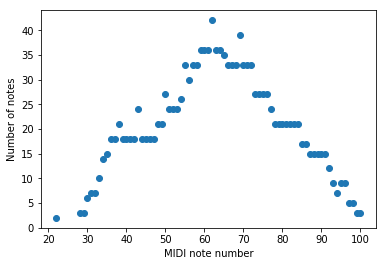

In [8]:
# check the pitches in the dataset

def get_tiny_sol_note_name(filename):
    return filename.split('/')[-1].split('-')[2]

# pull out the note name from the file string
def get_midi_pitch(filename):
    note_name = get_tiny_sol_note_name(filename)
    return(pretty_midi.note_name_to_number(note_name))

pitches = defaultdict(int)
for f in all_wav_files:
    pitches[get_midi_pitch(f)] += 1

plt.ylabel('Number of notes')
plt.xlabel('MIDI note number')
plt.scatter(pitches.keys(), pitches.values())

<h3> Compute some features - MFCC, FFT, etc.</h3>

In [9]:
# Just grab the first 2 seconds of each file?
max_duration = 2

f1 = all_wav_files[0]
f2 = all_wav_files[1]
y1, sr = librosa.load(f1, duration=max_duration)
y2, sr = librosa.load(f2, duration=max_duration)

In [10]:
mfcc1 = librosa.feature.mfcc(y1, n_mfcc=13)
mfcc2 = librosa.feature.mfcc(y2, n_mfcc=13)

fft1 = np.real(librosa.stft(y1))
fft2 = np.real(librosa.stft(y2))

mel_spec1 = librosa.feature.melspectrogram(y1)
mel_spec2 = librosa.feature.melspectrogram(y2)

mfcc1.shape, fft1.shape, mel_spec1.shape

((13, 87), (1025, 87), (128, 87))

In [11]:
def mix_sounds(s1, s2, c1, c2):
    return c1*s1 + c2*s2

play(mix_sounds(y1, y2, 1., 0.8), rate = sr)

In [12]:
def mean_squared_feature_distance(f1, f2):
    dists = np.mean(f1, axis=1) - np.mean(f2, axis=1)
    return np.dot(dists, dists)/len(dists)

In [13]:
d1 = mean_squared_feature_distance(mfcc1, mfcc2)
d2 = mean_squared_feature_distance(fft1, fft2)
d3 = mean_squared_feature_distance(mel_spec1, mel_spec2)

(d1, d2, d3)

(5918.74589009831, 0.037454048714986664, 794.6049640612182)

<h3> Data Version 1. Make training splits across all files, meaning don't partition by different instruments or pitches </h3>

In [14]:
split_1 = int(0.6 * len(all_wav_files))
split_2 = int(0.8 * len(all_wav_files))

train_files = all_wav_files[0:split_1]
dev_files = all_wav_files[split_1:split_2]
test_files = all_wav_files[split_2:]